# Overlay LC to create mask applied before for zonal stats of AGB
* to run zonal stats for certain land cover zones in WorldCover s3 dataset

In [10]:
import geopandas as gpd
import pandas as pd
import rasterio

import rioxarray
import fiona

In [2]:
# a writable outdir
outdir = '/projects/my-public-bucket/analyze_agb'

In [3]:
COVAR_FOOTPRINTS_FN = '/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg'

TILE_NUM = 131 #3417# 4253
INDEX_FN = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
INDEX_LYR = 'boreal_tiles_v003'

In [4]:
boreal_tiles = gpd.read_file(INDEX_FN)
tile_group_region_string = "america"
tiles_subset = boreal_tiles[boreal_tiles['tile_group'].str.contains(tile_group_region_string)]
tiles_subset.head()

,tile_num,tile_version,tile_group,map_version,geometry
328,329,version 1,north america east,None,"POLYGON ((4688522.000 7713304.000, 4778522.000..."
329,330,version 1,north america east,None,"POLYGON ((4778522.000 7713304.000, 4868522.000..."
330,331,version 1,north america east,None,"POLYGON ((4868522.000 7713304.000, 4958522.000..."
331,332,version 1,north america east,None,"POLYGON ((4958522.000 7713304.000, 5048522.000..."
357,358,version 1,north america east,None,"POLYGON ((4508522.000 7623304.000, 4598522.000..."


https://gis.stackexchange.com/questions/345917/overlay-two-raster-geotiffs-using-rasterio-mask

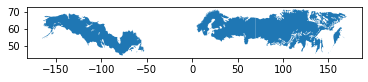

In [5]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres") )
alaska = world[world.name == 'United States of America'].explode().cx[-170:-50, 50:90]
canada = world[world.name == 'Canada']
canada_alaska = pd.concat([alaska, canada])
#canada_alaska.plot()
boreal_gdf = gpd.read_file('/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')
boreal_gdf.plot()

### Get the Worldcover covariate tiles

In [6]:
# Build a VRT of the LC on s3?
covar_footprint_tiles = gpd.read_file(COVAR_FOOTPRINTS_FN)
covar_footprint_tiles.head()

,footprint_name,path,file,s3_path,geometry
0,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E006_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((9.00000 0.00000, 9.00000 3.00000, 6...."
1,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E009_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((12.00000 0.00000, 12.00000 3.00000, ..."
2,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E012_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((15.00000 0.00000, 15.00000 3.00000, ..."
3,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E015_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((18.00000 0.00000, 18.00000 3.00000, ..."
4,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E018_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((21.00000 0.00000, 21.00000 3.00000, ..."


### Subset covariate tiles by region
* Build the spatial selector with 'intersects'
* do the subset accord to region (where region is identified with the spatial selector)

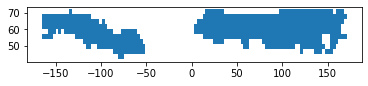

In [7]:
tile_group_region_string = 'wwf_boreal'

boreal_gdf['dissolve_field'] = 'for intersect'

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector = covar_footprint_tiles.intersects(boreal_gdf.dissolve(by='dissolve_field').iloc[0].geometry)
covar_footprint_tiles_subset = covar_footprint_tiles[selector]
covar_footprint_tiles_subset.plot()

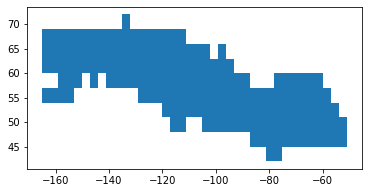

In [8]:
tile_group_region_string = tile_group_region_string + '_america'

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector = covar_footprint_tiles_subset.intersects(boreal_gdf.cx[-165:-50, 40:90].iloc[0].geometry)

covar_footprint_tiles_subset = covar_footprint_tiles_subset[selector]
covar_footprint_tiles_subset.plot()

In [9]:
# cog bands dict
bands_dict = {'1': 'esa_worldcover_v100_2020'
             }
import os
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

### Build the VRT of the Worldcover covar data on s3 for the region

In [28]:
for bandnum, bandname in bands_dict.items():
    
    print(bandnum, bandname)
    
    # Write a vrt list
    covar_vrt_list = os.path.join(outdir, f"cog_tindex.{bandname}.{tile_group_region_string}.txt")

    with open(covar_vrt_list, 'w') as f:

        for text in covar_footprint_tiles_subset['s3_path'].tolist():
            f.write(text.replace("s3:/","/vsis3") + '\n')
    
    # Make vrt name from text file name
    covar_vrt_fn = covar_vrt_list.replace('.txt','.vrt')

    #get the bbox as part of the gdalbuildvrt and define it, to save time calculating
    extent = [int(b) for b in covar_footprint_tiles_subset.total_bounds]
    
    extent_str = ' '.join(str(e) for e in extent)
    
    ###!time gdalbuildvrt -b 1 -te 458521 1503304 5408522 7623304 -input_file_list $vrt_list $vrt_fn
    !time gdalbuildvrt -b $bandnum -te $extent_str -input_file_list $covar_vrt_list $covar_vrt_fn
    print(covar_vrt_fn)

1 esa_worldcover_v100_2020
0...10...20...30...40...50...60...70...80...90...100 - done.

real	1m0.068s
user	0m0.868s
sys	0m0.063s


In [33]:
!pip install -U rioxarray

  Using cached rioxarray-0.9.1-py3-none-any.whl
  Using cached xarray-0.20.2-py3-none-any.whl (845 kB)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [12]:

import rioxarray
import fiona

covar_vrt_fn = '/projects/my-public-bucket/analyze_agb/cog_tindex.esa_worldcover_v100_2020.wwf_boreal_america.vrt'
vrt_fn = '/projects/my-public-bucket/analyze_agb/cog_tindex.agb_mean.america.vrt'
# open the rasters
rds1 = rioxarray.open_rasterio(covar_vrt_fn)
rds2 = rioxarray.open_rasterio(vrt_fn)

In [13]:
rds1

<xarray.DataArray (band: 1, y: 360000, x: 1368000)>
[492480000000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -165.0 -165.0 -165.0 -165.0 ... -51.0 -51.0 -51.0
  * y            (y) float64 72.0 72.0 72.0 72.0 72.0 ... 42.0 42.0 42.0 42.0
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [30]:
# Get a geom that matches some HYBAS_ID
with fiona.open('/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev04_v1c.gpkg') as src:
    geom_crs = src.crs_wkt
    for feature in src:
        if feature['properties']["HYBAS_ID"] == 8040007030:
            geom = feature["geometry"]

In [33]:
z = gpd.read_file('/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_NORTHERN_lev04_v1c.gpkg')
z.loc[0]

HYBAS_ID                                            8040000010
NEXT_DOWN                                                    0
NEXT_SINK                                           8040000010
MAIN_BAS                                            8040000010
DIST_SINK                                                  0.0
DIST_MAIN                                                  0.0
SUB_AREA                                               55238.6
UP_AREA                                                55238.6
PFAF_ID                                                   8111
SIDE                                                         M
LAKE                                                         0
ENDO                                                         0
COAST                                                        1
ORDER                                                        0
SORT                                                         1
geometry     (POLYGON ((-144.3680555555555 59.983333333

#### Why doesnt this clip work?

In [ ]:
clipped = rioxarray.open_rasterio(
    covar_vrt_fn,
    masked=True,
).rio.clip(z.loc[0].geometry, from_disk=True)
#rds1_clipped = rds1.rio.clip(geom, geom_crs)

In [ ]:
if False:
    rds1_clipped = rds1.rio.clip(geoms, geom_crs)
    rds2_clipped = rds2.rio.clip(geoms, geom_crs)

    # ensure the rasters have the same projection/transform/shape
    rds2_match = rds2_clipped.rio.reproject_match(rds2_clipped)

## Loop over Worldcover classes, providing them as masks to AGB raster
https://gis.stackexchange.com/questions/345917/overlay-two-raster-geotiffs-using-rasterio-mask
* build this into ExtractUtils.get_raster_zonalstats()

In [ ]:


try:

    #out_image, out_transform = rasterio.mask.mask(dataset=r, shapes=feature_gdf.geometry, crop=True)
    # the shapes are the geometry of the regional hydrobasin
    out_image, out_transform = rasterio.mask.mask(dataset=r, shapes=ZONAL_STATS_DICT[]'REGION_FN'], crop=True)

    # Copy the metadata
    out_meta = r.meta.copy()
    out_meta.update({"driver": "GTiff",
             "height": out_image.shape[1],
             "width": out_image.shape[2],
             "transform": out_transform,
             "crs":r.crs.to_proj4()}
                     )
    with rasterio.open(out_r_fn, "w", **out_meta) as out_r:
        out_r.write(out_image)

        print("Zone", zonenum, "clip of",  os.path.split(r_fn)[1])
        print("Writing clipped subset to", out_r_fn)

        #show(out_r, cmap='viridis') # <-- this show() is not working here..need to read the raster in again?

    # HERE IS WHERE WE CAN DO rasterstat's zonal_stats.
    if SHOW_CLIP:
        show((rasterio.open(out_r_fn)), cmap='viridis')# <-- this show() works

except ValueError:
    print(zone_name, " has no intersection with", os.path.split(r_fn)[1])
    no_raster_intersection_list.append(zone_name)

In [ ]:
import rioxarray
import fiona

# open the rasters
rds1 = rioxarray.open_rasterio("21_32/LC080210322016072801T1/LC08_L1TP_021032_20160728_20170221_01_T1_sr_band3.tif")
rds2 = rioxarray.open_rasterio("CDL_2018_18.tif")

# clip the rasters
with fiona.open(parc_2018, layer='County_Land_Parcels_IGIO_IN_Apr2018') as src:
    geom_crs = src.crs_wkt
    geoms = [feature["geometry"] for feature in src]

rds1_clipped = rds1.rio.clip(geoms, geom_crs)
rds2_clipped = rds2.rio.clip(geoms, geom_crs)

# ensure the rasters have the same projection/transform/shape
rds2_match = rds2_clipped.rio.reproject_match(rds2_clipped)

# write to file
rds1_clipped.rio.to_raster("LC08_L1TP_021032_20160728_20170221_01_T1_sr_band3__clipped.tif")
rds2_match.rio.to_raster("CDL_2018_18__clipped_reprojected.tif")

## For a tile, run build_stack.py

In [ ]:
args = f"--in_tile_fn {INDEX_FN} \
--in_tile_num {TILE_NUM} \
--tile_buffer_m 0 \
--in_tile_layer {INDEX_LYR} \
-o /projects/test_data/ \
--topo_off \
--covar_src_name esa_worldcover_v100_2020 \
--covar_tile_fn {COVAR_FOOTPRINTS_FN} \
--in_covar_s3_col s3_path \
--input_nodata_value 0"
print(args)
!python build_stack.py $args